<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/brace_adjust_padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github/capstone/brace

/content/drive/MyDrive/Github/capstone/brace


In [ ]:
%ls

 annotations/      dataset/             lstm_model2.pth         tensor_dataset.pkl
 bracedataset.py   dataset_pytorch.py   lstm_model.pth          test_subset.pkl
 brace_test.pkl    figures/            'MODELS ACCURACY.gdoc'   train_subset.pkl
 brace_test.pth    keras_model/         names                   utils/
 brace_train.pkl   k_model_features/    path/                   videos_info.csv
 brace_train.pth   k_model_features2/   __pycache__/
 dataClips         labels               README.md


In [ ]:
# !nvidia-smi

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone/brace')

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import bracedataset
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import TensorDataset
from tqdm import tqdm
from pathlib import PosixPath
import pickle
import re
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.optim.lr_scheduler import ExponentialLR
import json
from pathlib import Path

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt
import seaborn as sns

Obtain BRACE dataset clips and labels, only need to to this once, they are saved for future reference


In [ ]:
####### Categories {'toprock': 0, 'powermove': 1, 'footwork': 2}

CNN model with RNN layer


In [ ]:
# @title
# #load paths
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels, names=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# with open("dataClips", "wb") as fp:   #Pickling
#     pickle.dump(dataClips, fp)
# with open("labels", "wb") as fp:   #Pickling
#     pickle.dump(labels, fp)
# with open("names", "wb") as fp:   #Pickling
#     pickle.dump(names, fp)


In [ ]:
# Load the TensorDataset
with open('dataClips', 'rb') as f:
    dataClips = pickle.load(f)

# Load the training Subset
with open('labels', 'rb') as f:
    labels = pickle.load(f)

# Load the testing Subset
with open('names', 'rb') as f:
    names = pickle.load(f)

#encode labels from 0-2
unique_categories = list(set(labels))
category_to_int = {category: index for index, category in enumerate(unique_categories)}
encoded_categories = [category_to_int[category] for category in labels]

In [ ]:
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]

padded_clips = pad_sequences(flattened_clips, padding='post', dtype='float32')


In [ ]:
### KERAS CNN MODEL######

X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2])),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                17000     
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
27/27 [==============================] - 18s 536ms/step - loss: 1.0997 - accuracy: 0.3113 - val_loss: 1.0991 - val_accuracy: 0.2949
Epoch 2/1

In [ ]:
# @title
# model.save('/content/drive/MyDrive/Github/capstone/brace/keras_model')
# Load the model
loaded_model = load_model('path/to/location/keras_model')

# test
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accuracy}')

9/9 [==============================] - 2s 131ms/step - loss: 1.0955 - accuracy: 0.3616
Test Accuracy: 0.361623615026474


INCLUDE FEATURES IN THE MODEL

In [ ]:
# @title
#sort additional features
features= segments.copy()
features['uid']= pd.Categorical(features['uid'], categories=names, ordered=True)
features= features.sort_values(by='uid')
features['frames']= features['end_frame']- features['start_frame']


In [ ]:
# @title
# One-hot encode
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('cat', OneHotEncoder(), ['dancer_id']),
        ('num', OneHotEncoder(), ['year']),

    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'dancer_id', 'year']])
features_preprocessed = features_preprocessed.toarray()
features_preprocessed[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
# @title
# split train, test
X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

In [ ]:
# @title
# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50)(keypoint_input)
keypoint_model = Dense(100, activation='relu')(keypoint_model)

# Additional features input branch
additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu')(additional_features_input)

# Concatenate the outputs of the two branches
combined = concatenate([keypoint_model, features_model])

# Add a classification layer
combined = Dense(100, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# Build the model
model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 1280, 34)]           0         []                            
 )                                                                                                
                                                                                                  
 lstm (LSTM)                 (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 78)]                 0         []                            
 )                                                                                                
                                                                                              

In [ ]:
# @title
history = model.fit([X_train_clips, X_train_features], y_train_onehot, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
27/27 [==============================] - 18s 543ms/step - loss: 1.0998 - accuracy: 0.3414 - val_loss: 1.1071 - val_accuracy: 0.3041
Epoch 2/10
27/27 [==============================] - 10s 359ms/step - loss: 1.0954 - accuracy: 0.3519 - val_loss: 1.1055 - val_accuracy: 0.3318
Epoch 3/10
27/27 [==============================] - 11s 417ms/step - loss: 1.0825 - accuracy: 0.4155 - val_loss: 1.1165 - val_accuracy: 0.3226
Epoch 4/10
27/27 [==============================] - 12s 432ms/step - loss: 1.0833 - accuracy: 0.4120 - val_loss: 1.1128 - val_accuracy: 0.3088
Epoch 5/10
27/27 [==============================] - 12s 432ms/step - loss: 1.0713 - accuracy: 0.4306 - val_loss: 1.1167 - val_accuracy: 0.3134
Epoch 6/10
27/27 [==============================] - 11s 415ms/step - loss: 1.0555 - accuracy: 0.4630 - val_loss: 1.1219 - val_accuracy: 0.3134
Epoch 7/10
27/27 [==============================] - 10s 388ms/step - loss: 1.0554 - accuracy: 0.4606 - val_loss: 1.1293 - val_accuracy: 0.3226

In [ ]:
# @title
model.save('/content/drive/MyDrive/Github/capstone/brace/k_model_features')
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Github/capstone/brace/k_model_features')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}") #0.31

9/9 [==============================] - 1s 118ms/step - loss: 1.1632 - accuracy: 0.3247
Test Loss: 1.1632002592086792
Test Accuracy: 0.3247232437133789


CHANGE FEATURES TO SEQUENCE AND CLIP LENGHT, TO TEST IF THERE IS LESS OVERFITTING

In [ ]:
# @title
# One-hot encode
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('frames', OneHotEncoder(), ['frames'])
    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'frames']])
features_preprocessed = features_preprocessed.toarray()
features_preprocessed.shape

(1352, 505)

In [ ]:
# @title
# #### KERAS FEATURE MODEL2#####

# X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
#     padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


# y_train_onehot = to_categorical(y_train, num_classes=3)
# y_test_onehot = to_categorical(y_test, num_classes=3)

# # Keypoint input branch
# keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
# keypoint_model = LSTM(50)(keypoint_input)
# keypoint_model = Dense(100, activation='relu')(keypoint_model)

# # Additional features input branch
# additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
# features_model = Dense(50, activation='relu')(additional_features_input)

# # Concatenate the outputs of the two branches
# combined = concatenate([keypoint_model, features_model])

# # Add a classification layer
# combined = Dense(100, activation='relu')(combined)
# combined = Dropout(0.5)(combined)
# output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# # Build the model
# model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Model summary to check architecture
# model.summary()

In [ ]:
# @title

X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50, recurrent_regularizer=l1_l2(l1=0.01, l2=0.01))(keypoint_input)  # Adding regularization to LSTM
keypoint_model = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(keypoint_model)  # Adding regularization
keypoint_model = Dropout(0.5)(keypoint_model)  # Adding dropout

# Additional features input branch
additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(additional_features_input)  # Adding regularization
features_model = Dropout(0.5)(features_model)  # Adding dropout

# Concatenate the outputs of the two branches
combined = concatenate([keypoint_model, features_model])

# Add a classification layer
combined = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(combined)  # Adding regularization
combined = Dropout(0.5)(combined)  # Adding dropout
output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# Build the model
model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 1280, 34)]           0         []                            
 )                                                                                                
                                                                                                  
 lstm_1 (LSTM)               (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 505)]                0         []                            
 )                                                                                                
                                                                                            

In [ ]:
# @title
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    [X_train_clips, X_train_features], y_train_onehot,
    validation_data=([X_test_clips, X_test_features], y_test_onehot),
    epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
34/34 [==============================] - 28s 714ms/step - loss: 30.7461 - accuracy: 0.3358 - val_loss: 22.2211 - val_accuracy: 0.3542
Epoch 2/100
34/34 [==============================] - 34s 1s/step - loss: 16.2763 - accuracy: 0.3525 - val_loss: 10.8972 - val_accuracy: 0.3616
Epoch 3/100
34/34 [==============================] - 20s 597ms/step - loss: 7.5851 - accuracy: 0.3228 - val_loss: 4.8566 - val_accuracy: 0.3616
Epoch 4/100
34/34 [==============================] - 24s 686ms/step - loss: 3.4924 - accuracy: 0.3321 - val_loss: 2.3563 - val_accuracy: 0.3616
Epoch 5/100
34/34 [==============================] - 29s 856ms/step - loss: 1.8171 - accuracy: 0.3191 - val_loss: 1.4518 - val_accuracy: 0.3616
Epoch 6/100
34/34 [==============================] - 29s 866ms/step - loss: 1.3050 - accuracy: 0.3599 - val_loss: 1.2047 - val_accuracy: 0.3616
Epoch 7/100
34/34 [==============================] - 25s 733ms/step - loss: 1.1854 - accuracy: 0.3377 - val_loss: 1.1714 - val_accuracy

In [ ]:

model.save('/content/drive/MyDrive/Github/capstone/brace/k_model_features3')
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Github/capstone/brace/k_model_features3')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)
print(f"Model name: {loaded_model}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 1s 137ms/step - loss: 1.3042 - accuracy: 0.3321
Test Loss: 1.304213285446167
Test Accuracy: 0.33210331201553345


Try Dynamic Time Warping


In [ ]:
# @title
pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.1 MB/s eta 0:00:00


In [ ]:
# @title
from dtaidistance import dtw
from dtaidistance import dtw
from dtaidistance import clustering
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# @title
dtw_means=[]
for i in dataClips:
    data=i
    data_flattened = [clip.reshape(clip.shape[0], -1) for clip in data]
    distance_matrix = dtw.distance_matrix_fast(data_flattened)
    mean_dist=distance_matrix.mean()
    dtw_means.append(mean_dist)

In [ ]:
# @title
len(dtw_means)


1352

Clustering with Dynamic Time Warping

In [ ]:
# @title
cluster_df=features[['seq_idx', 'frames']].copy()
cluster_df['dtw']= pd.Series(dtw_means)
cluster_df.shape

(1352, 3)

In [ ]:
# @title
scaler = StandardScaler()
clusters_scaled = scaler.fit_transform(cluster_df)
pca = PCA(n_components=2)
clusters_pca = pca.fit_transform(clusters_scaled)
pca_df = pd.DataFrame(data=clusters_pca, columns=['Principal Component 1', 'Principal Component 2'])

In [ ]:
# @title
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['Principal Component 1', 'Principal Component 2']])
pca_df['ActualLabels'] = encoded_categories

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


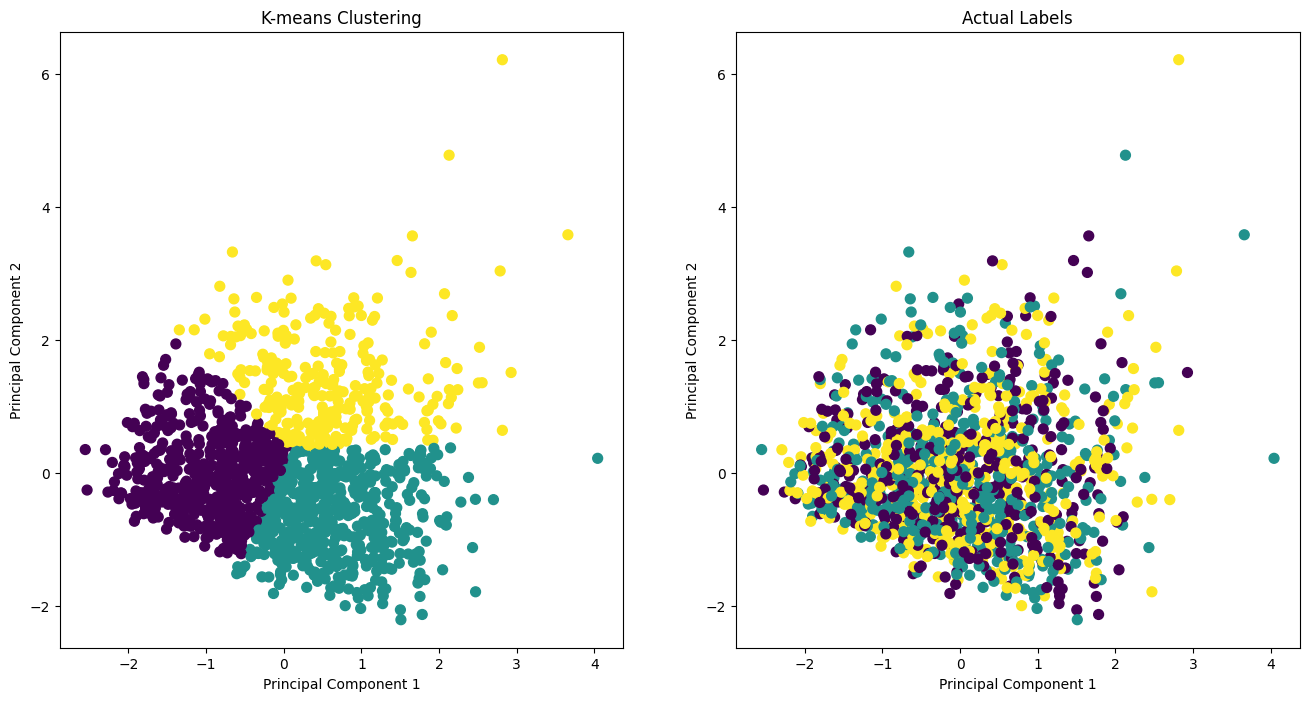

In [ ]:
# @title
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# K-means Cluster Plot
ax[0].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', s=50)
ax[0].set_title('K-means Clustering')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

# Actual Labels Plot
ax[1].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['ActualLabels'], cmap='viridis', s=50)
ax[1].set_title('Actual Labels')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')

plt.show()

In [ ]:
padded_clips.shape[1], 17, 2, 1

(1280, 17, 2, 1)

Time Distributed CNN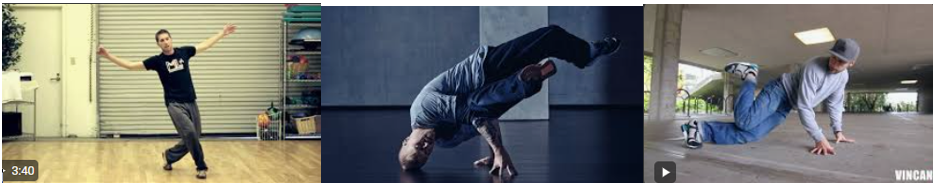

In [ ]:
####### Time Distributed CNN
#train test set
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

input_shape = (padded_clips.shape[1], 17, 2, 1)

model = Sequential([
    TimeDistributed(Conv1D(32, kernel_size=3, activation='relu'), input_shape=(1280, 34, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),

    LSTM(50),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')

])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, 1280, 32, 32)      128       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 1280, 16, 32)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 1280, 512)         0         
 istributed)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 50)                112600    
                                                                 
 dense_10 (Dense)            (None, 100)               5100      
                                                      

In [ ]:
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
27/27 [==============================] - 112s 4s/step - loss: 1.0994 - accuracy: 0.3380 - val_loss: 1.1016 - val_accuracy: 0.2949
Epoch 2/10
27/27 [==============================] - 119s 4s/step - loss: 1.0984 - accuracy: 0.3495 - val_loss: 1.1011 - val_accuracy: 0.2949
Epoch 3/10
27/27 [==============================] - 103s 4s/step - loss: 1.0980 - accuracy: 0.3484 - val_loss: 1.1029 - val_accuracy: 0.2949
Epoch 4/10
27/27 [==============================] - 99s 4s/step - loss: 1.0980 - accuracy: 0.3275 - val_loss: 1.1027 - val_accuracy: 0.2949
Epoch 5/10
27/27 [==============================] - 102s 4s/step - loss: 1.0968 - accuracy: 0.3495 - val_loss: 1.1038 - val_accuracy: 0.2949
Epoch 6/10
27/27 [==============================] - 108s 4s/step - loss: 1.0973 - accuracy: 0.3472 - val_loss: 1.1035 - val_accuracy: 0.2949
Epoch 7/10
27/27 [==============================] - 116s 4s/step - loss: 1.0979 - accuracy: 0.3472 - val_loss: 1.1025 - val_accuracy: 0.2949
Epoch 8/10
27/

In [ ]:

model.save('/content/drive/MyDrive/Github/capstone/brace/timeDistModel')
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Github/capstone/brace/timeDistModel')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test], y_test_onehot)
print(f"Model name: {loaded_model}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 11s 1s/step - loss: 1.0986 - accuracy: 0.3616
Model name: <keras.src.engine.sequential.Sequential object at 0x7e54783170d0>
Test Loss: 1.0985870361328125
Test Accuracy: 0.361623615026474


Analysis the angles of the hip-knee-ankle

In [ ]:
#calculate angle of the hip, knee and elbow
def calculate_angle(p1, p2, p3):
    ba = p1 - p2
    bc = p3 - p2
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

#calculate angles
def calculate_leg_angles(sequence, keypoints):
    """Calculate angles for a limb across all poses in a sequence, given flattened pose data."""
    angles = []
    for pose in sequence:
        # Extract x and y coordinates for each keypoint from the flattened pose array
        hip_x, hip_y = pose[keypoints[0]*2], pose[keypoints[0]*2 + 1]
        knee_x, knee_y = pose[keypoints[1]*2], pose[keypoints[1]*2 + 1]
        ankle_x, ankle_y = pose[keypoints[2]*2], pose[keypoints[2]*2 + 1]

        # Reconstruct the [x, y] vectors for each keypoint
        hip = np.array([hip_x, hip_y])
        knee = np.array([knee_x, knee_y])
        ankle = np.array([ankle_x, ankle_y])

        # Calculate the angle using the reconstructed vectors
        angle = calculate_angle(hip, knee, ankle)
        angles.append(angle)
    return np.mean(angles)
#Extract and average angles for the right and left legs across sequences.
def extract_angles_from_dataset(data, labels, right_keypoints, left_keypoints):

    angles_right = []
    angles_left = []
    class_angles = {label: {'right': [], 'left': []} for label in np.unique(labels)}

    for sequence, label in zip(data, labels):
        angle_right = calculate_leg_angles(sequence, right_keypoints)
        angle_left = calculate_leg_angles(sequence, left_keypoints)
        class_angles[label]['right'].append(angle_right)
        class_angles[label]['left'].append(angle_left)

    return class_angles

In [ ]:
# Keypoint indices for right and left legs
right_keypoints = [12, 14, 16]
left_keypoints = [11, 13, 15]

In [ ]:
flattened_clips[0][0].shape

(34,)

In [ ]:
class_angles = extract_angles_from_dataset(flattened_clips, encoded_categories, right_keypoints, left_keypoints)


In [ ]:
category_to_int= {'toprock': 0, 'powermove': 1, 'footwork': 2}

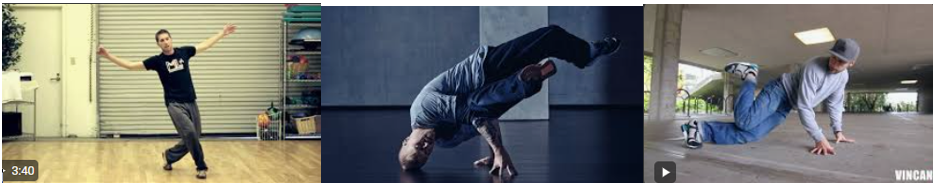

In [ ]:
body_parts_list = [(0, "Nose"), (1, "Left Eye"), (2, "Right Eye"), (3, "Left Ear"), (4, "Right Ear"), (5, "Left Shoulder"), (6, "Right Shoulder"),
                   (7, "Left Elbow"), (8, "Right Elbow"), (9, "Left Wrist"), (10, "Right Wrist"), (11, "Left Hip"), (12, "Right Hip"),
                   (13, "Left Knee"), (14, "Right Knee"), (15, "Left Ankle"), (16, "Right Ankle")]
body_parts_dict= {word: number for number, word in body_parts_list}
body_parts_dict

{'Nose': 0,
 'Left Eye': 1,
 'Right Eye': 2,
 'Left Ear': 3,
 'Right Ear': 4,
 'Left Shoulder': 5,
 'Right Shoulder': 6,
 'Left Elbow': 7,
 'Right Elbow': 8,
 'Left Wrist': 9,
 'Right Wrist': 10,
 'Left Hip': 11,
 'Right Hip': 12,
 'Left Knee': 13,
 'Right Knee': 14,
 'Left Ankle': 15,
 'Right Ankle': 16}

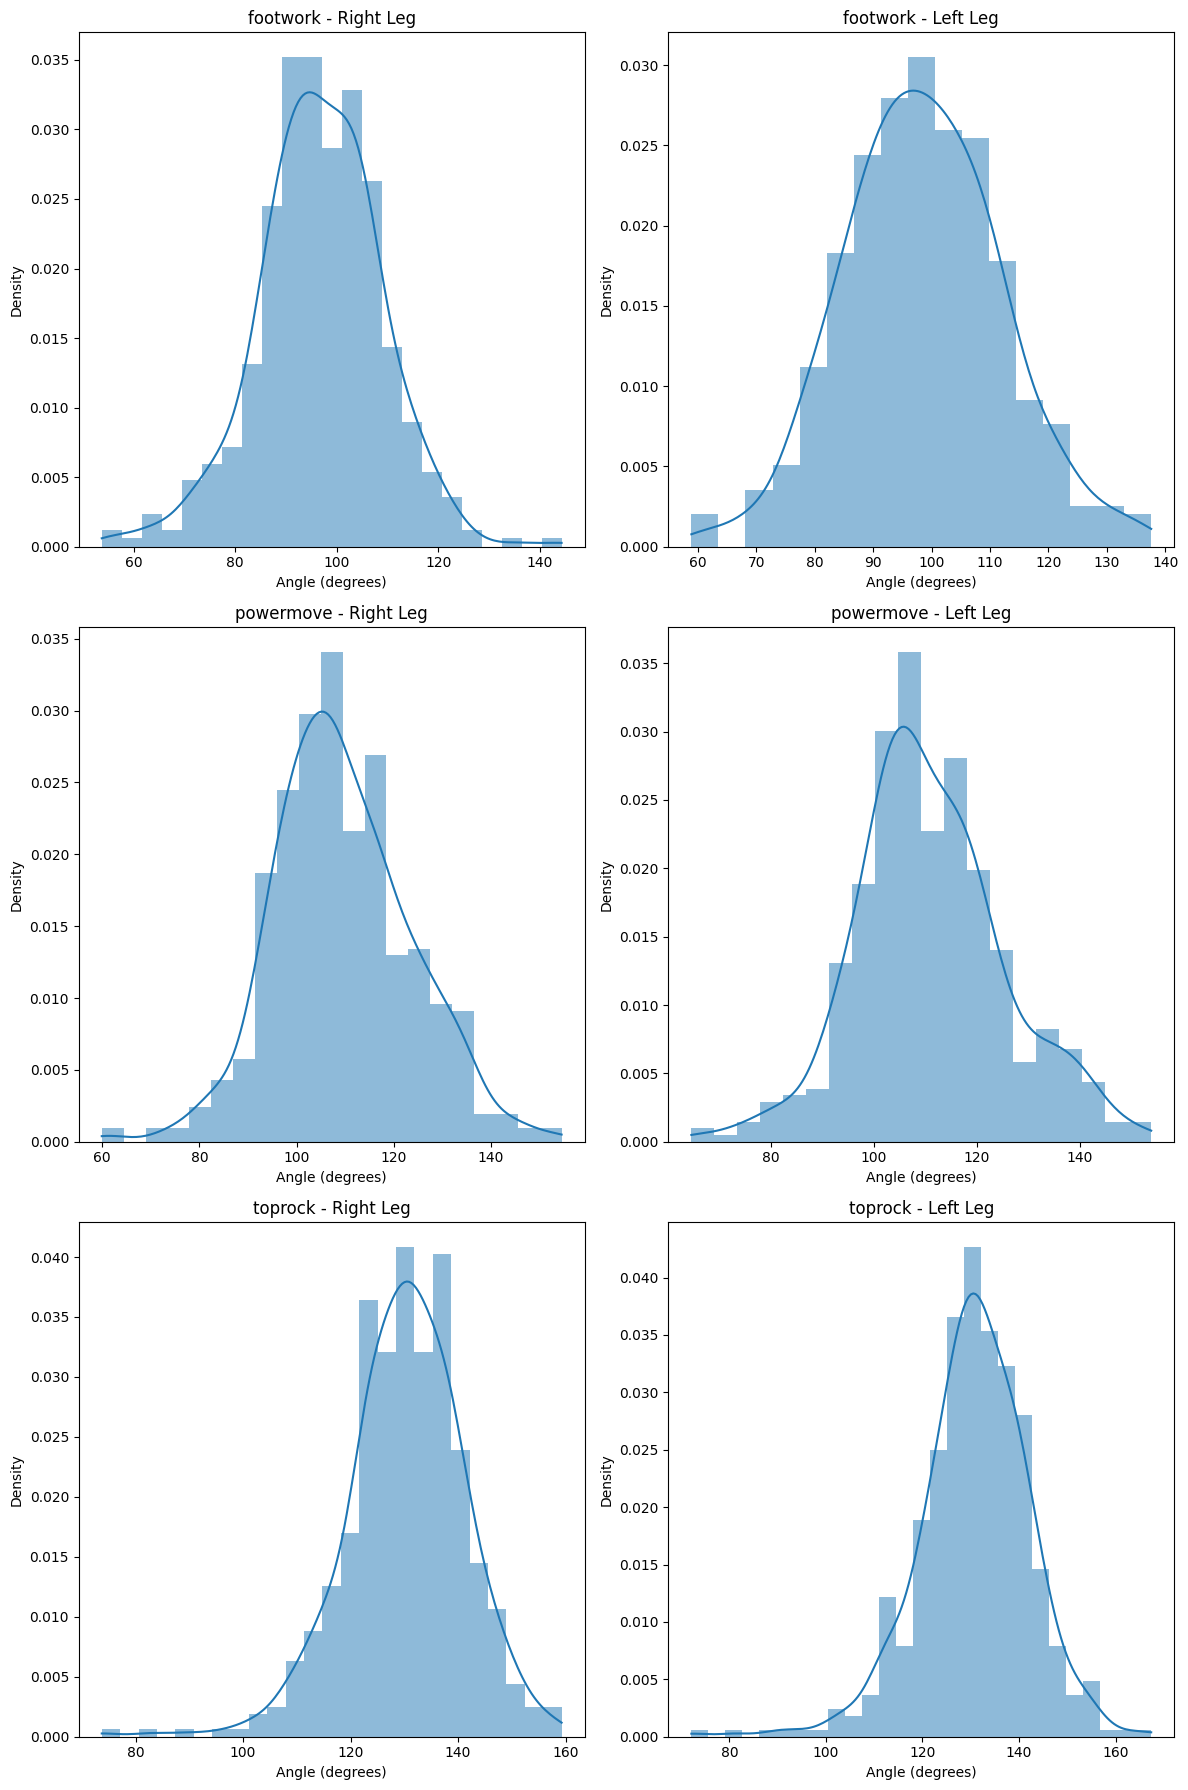

In [ ]:
def plot_angle_distributions_3x2_with_category_names(class_angles, category_to_int):
    """Plot angle distributions in a 3x2 format, with category names for each class and leg side."""
    # Create a figure with 3 rows and 2 columns of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Create a reverse mapping from integer labels to category names
    int_to_category = {v: k for k, v in category_to_int.items()}

    # Sort the class labels to ensure consistent plotting order
    sorted_labels = sorted(class_angles.keys(), key=lambda x: int_to_category[x])

    # Iterate through each class and plot right and left leg angles
    for i, label in enumerate(sorted_labels):
        category_name = int_to_category[label]  # Convert label to category name

        # Right leg plot for current class
        ax_right = axes[i*2]  # Even indices for right leg
        sns.histplot(class_angles[label]['right'], kde=True, ax=ax_right, stat="density", linewidth=0)
        ax_right.set_title(f'{category_name} - Right Leg')
        ax_right.set_xlabel('Angle (degrees)')
        ax_right.set_ylabel('Density')

        # Left leg plot for current class
        ax_left = axes[i*2 + 1]  # Odd indices for left leg
        sns.histplot(class_angles[label]['left'], kde=True, ax=ax_left, stat="density", linewidth=0)
        ax_left.set_title(f'{category_name} - Left Leg')
        ax_left.set_xlabel('Angle (degrees)')
        ax_left.set_ylabel('Density')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Assuming class_angles is already calculated and contains the angle data
# And assuming category_to_int is your category mapping dictionary
plot_angle_distributions_3x2_with_category_names(class_angles, category_to_int)

In [ ]:
def calculate_mean_angles(class_angles):
    mean_angles = {}
    for label in class_angles:
        # Calculate mean angle for right leg
        mean_right = np.mean(class_angles[label]['right'])
        # Calculate mean angle for left leg
        mean_left = np.mean(class_angles[label]['left'])
        # Store the mean angles in the dictionary
        mean_angles[label] = {'right': mean_right, 'left': mean_left}
    return mean_angles

# Assuming class_angles is already calculated and contains the angle data
mean_angles = calculate_mean_angles(class_angles)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Leg Angle: {mean_angles[label]['right']:.2f}, Mean Left Leg Angle: {mean_angles[label]['left']:.2f}")

Class toprock - Mean Right Leg Angle: 130.20, Mean Left Leg Angle: 130.64
Class powermove - Mean Right Leg Angle: 109.39, Mean Left Leg Angle: 110.93
Class footwork - Mean Right Leg Angle: 96.61, Mean Left Leg Angle: 98.48


In [ ]:
def calculate_angle_to_horizontal(hip, knee):
    """Calculate the angle between the limb (hip to knee) and the horizontal axis."""
    limb_vector = np.array(knee) - np.array(hip)
    angle_rad = np.arctan2(limb_vector[1], limb_vector[0])
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def calculate_leg_angles(sequence, keypoints):
    """Calculate angles for a limb across all poses in a sequence."""
    angles = []
    for pose in sequence:
        # Assuming pose is flattened and contains x, y sequentially for each keypoint
        hip_x, hip_y = pose[keypoints[0]*2], pose[keypoints[0]*2+1]
        knee_x, knee_y = pose[keypoints[1]*2], pose[keypoints[1]*2+1]
        hip = [hip_x, hip_y]
        knee = [knee_x, knee_y]
        angle = calculate_angle_to_horizontal(hip, knee)
        angles.append(angle)
    return angles

def extract_horizontal_angles_from_df(data, labels, right_keypoints, left_keypoints):
    class_angles = {label: {'right': [], 'left': []} for label in np.unique(labels)}

    for sequence, label in zip(data, labels):
        angles_right = calculate_leg_angles(sequence, right_keypoints)
        angles_left = calculate_leg_angles(sequence, left_keypoints)

        # Append the list of angles for the sequence to the class entry
        class_angles[label]['right'].extend(angles_right)
        class_angles[label]['left'].extend(angles_left)

    return class_angles

In [ ]:
# Keypoint indices for right and left legs (hip, knee)
right_keypoints = [12, 14]  # right hip, right knee
left_keypoints = [11, 13]  # left hip, left knee

# Assuming 'data' is your padded_clips and 'labels' correspond to y_train
hrz_class_angles = extract_horizontal_angles_from_df(flattened_clips, encoded_categories, right_keypoints, left_keypoints)


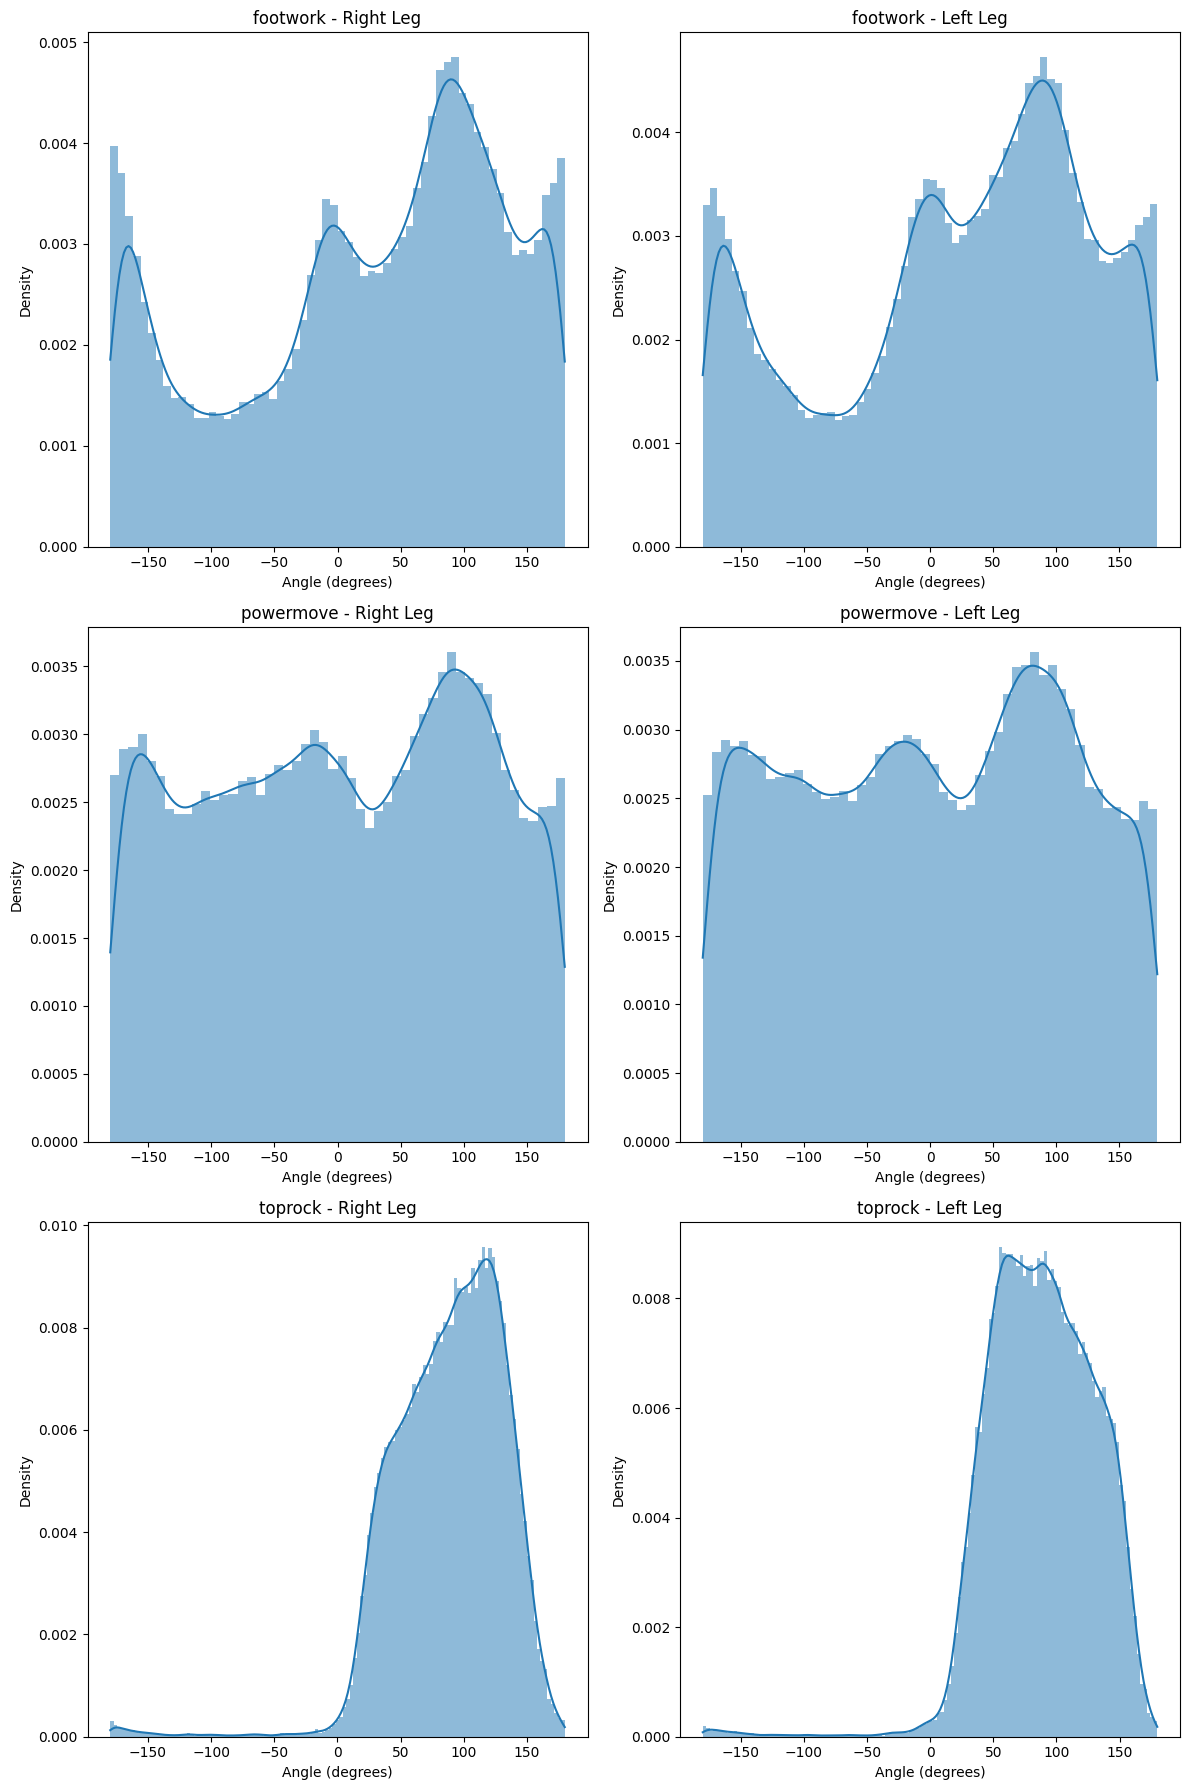

In [ ]:
plot_angle_distributions_3x2_with_category_names(hrz_class_angles, category_to_int)

In [ ]:
# Assuming class_angles is already calculated and contains the angle data
mean_horz_angles = calculate_mean_angles(hrz_class_angles)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_horz_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Leg Angle: {mean_horz_angles[label]['right']:.2f}, Mean Left Leg Angle: {mean_horz_angles[label]['left']:.2f}")

Class toprock - Mean Right Leg Angle: 88.57, Mean Left Leg Angle: 88.14
Class powermove - Mean Right Leg Angle: 2.85, Mean Left Leg Angle: 1.01
Class footwork - Mean Right Leg Angle: 24.52, Mean Left Leg Angle: 21.24


In [ ]:
def calculate_head_position(pose):
    """Calculate the average y-coordinate of head keypoints as head position."""
    # Indices for head keypoints: nose=0, left_eye=1, right_eye=2, left_ear=3, right_ear=4
    head_indices = [0, 1, 2, 3, 4]
    y_coords = [pose[i*2+1] for i in head_indices]  # Multiplying by 2 and adding 1 to get y-coordinate from flattened pose
    avg_y = np.mean(y_coords)
    return avg_y

def calculate_head_to_floor_distance(pose):
    """Estimate distance from head to 'floor' by comparing head position to lowest keypoint."""
    head_position = calculate_head_position(pose)
    # Assuming pose is flattened, even indices are x-coords, odd are y-coords
    y_coords = pose[1::2]  # Get all y-coordinates
    lowest_y = max(y_coords)  # The 'floor' is at the max y-coordinate
    distance = lowest_y - head_position
    return distance

def extract_head_to_floor_distances(data, labels, category_to_int):
    class_distances = {}  # Start with an empty dictionary

    for sequence, label in zip(data, labels):
        distances = [calculate_head_to_floor_distance(pose) for pose in sequence]
        avg_distance = np.mean(distances) if distances else None
        class_name = [name for name, num in category_to_int.items() if num == label][0]

        # Dynamically add class keys to the dictionary if they don't exist
        if class_name not in class_distances:
            class_distances[class_name] = {'head_to_floor': []}

        class_distances[class_name]['head_to_floor'].append(avg_distance)

    return class_distances

In [ ]:
# Example usage with a single pose
pose = flattened_clips[0][0]  # Assuming this is the first pose of the first clip, and the structure is [x0, y0, x1, y1, ...]
distance = calculate_head_to_floor_distance(pose)
print(f"Estimated distance from head to floor: {distance}")

Estimated distance from head to floor: 0.9747977988408315


In [ ]:
head_to_floor_distances = extract_head_to_floor_distances(flattened_clips, encoded_categories, category_to_int)

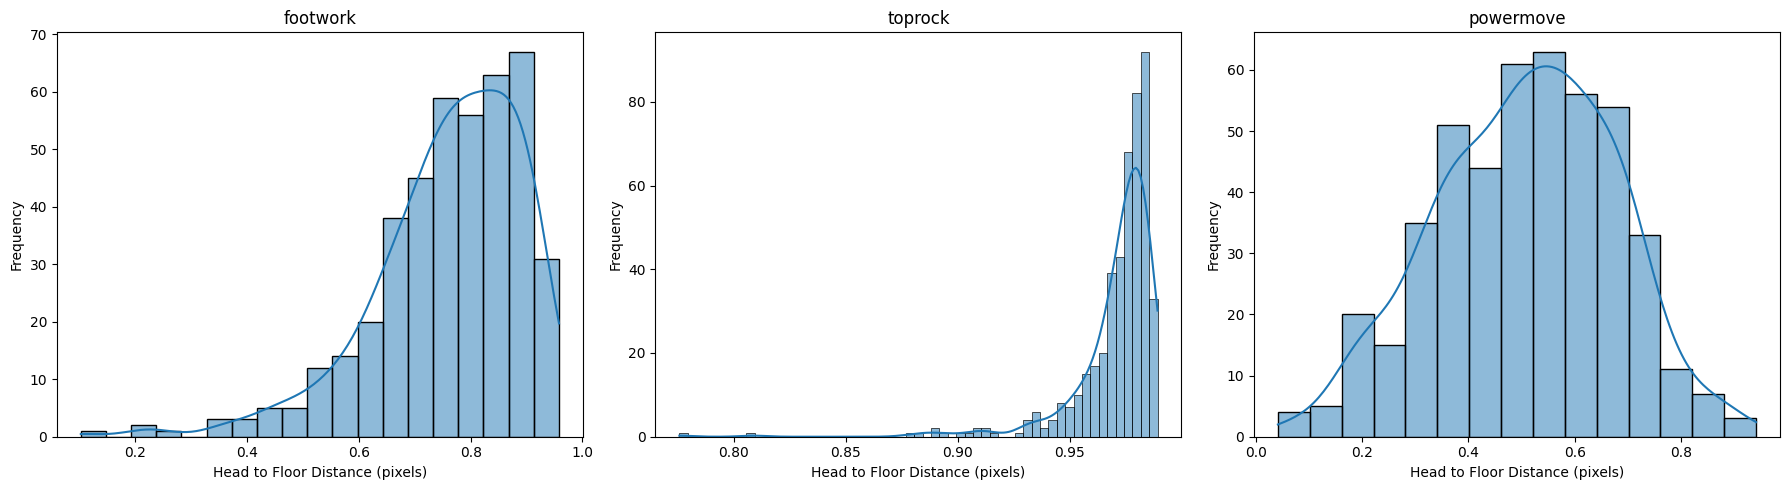

In [ ]:
def plot_head_to_floor_histograms(class_distances):
    """Plot 1x3 histograms of head-to-floor distances for each class."""
    # Determine the number of classes to set figure size dynamically
    num_classes = len(class_distances)
    plt.figure(figsize=(6 * num_classes, 5))  # Adjust figure size as needed

    for i, (class_name, distances) in enumerate(class_distances.items(), start=1):
        plt.subplot(1, num_classes, i)
        # Assuming distances for each class are stored under 'head_to_floor' key
        sns.histplot(distances['head_to_floor'], kde=True)
        plt.title(f'{class_name}')
        plt.xlabel('Head to Floor Distance (pixels)')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
plot_head_to_floor_histograms(head_to_floor_distances)


In [ ]:
def calculate_mean_distance(floor_distance):
    mean_head_dist={}
    for  label in floor_distance:
        mean_h=np.mean(floor_distance[label]['head_to_floor'])
        mean_head_dist[label]= mean_h
    return mean_head_dist

head_dist= calculate_mean_distance(head_to_floor_distances)

head_dist

{'footwork': 0.7607817715982209,
 'toprock': 0.9708167567989453,
 'powermove': 0.5077703016672418}

In [ ]:
def calculate_hand_to_floor_distance(pose, wrist_index):
    """Calculate the distance from a hand (wrist) to the 'floor' in a pose."""
    # Extract y-coordinate for the specified wrist (hand)
    wrist_y = pose[wrist_index * 2 + 1]  # Multiply by 2 and add 1 to get y-coordinate from flattened pose

    # Assuming all y-coordinates are at odd indices in the pose array
    floor_y = max(pose[1::2])  # 'Floor' is at the max y-coordinate

    return floor_y - wrist_y  # Distance from wrist to 'floor'

def extract_hand_to_floor_distances(data, labels):
    """Extract hand to floor distances for each sequence, organized by class."""
    class_distances = {label: {'left_hand': [], 'right_hand': []} for label in np.unique(labels)}

    # Keypoint indices for left and right wrists (adjust according to your data)
    left_wrist_index = 9
    right_wrist_index = 10

    for sequence, label in zip(data, labels):
        left_distances = [calculate_hand_to_floor_distance(pose, left_wrist_index) for pose in sequence]
        right_distances = [calculate_hand_to_floor_distance(pose, right_wrist_index) for pose in sequence]


        class_distances[label]['left_hand'].append(np.mean(left_distances))
        class_distances[label]['right_hand'].append(np.mean(right_distances))

    return class_distances

In [ ]:
hand_to_floor_distances = extract_hand_to_floor_distances(flattened_clips, encoded_categories)


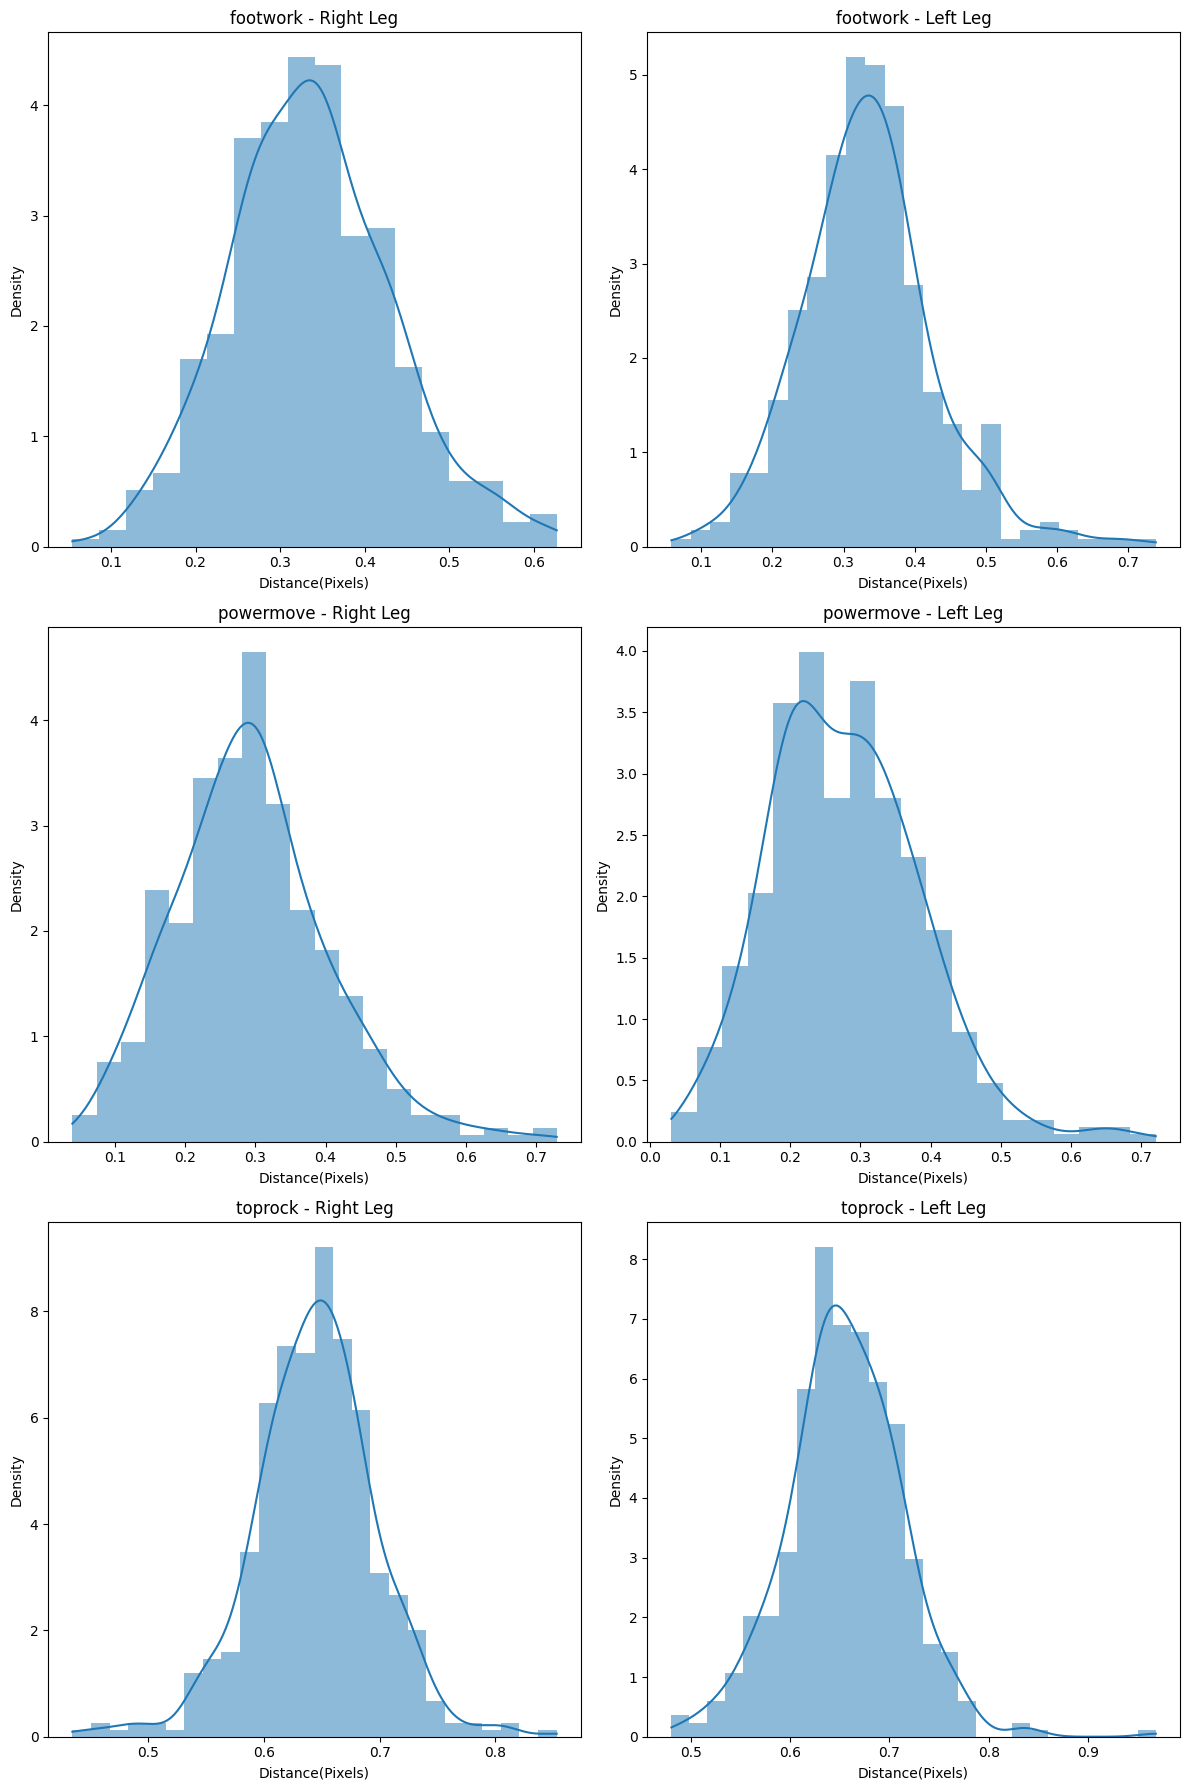

In [ ]:
def plot_hand_distance_3x2_with_category_names(class_angles, category_to_int):
    """Plot angle distributions in a 3x2 format, with category names for each class and leg side."""
    # Create a figure with 3 rows and 2 columns of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Create a reverse mapping from integer labels to category names
    int_to_category = {v: k for k, v in category_to_int.items()}

    # Sort the class labels to ensure consistent plotting order
    sorted_labels = sorted(class_angles.keys(), key=lambda x: int_to_category[x])

    # Iterate through each class and plot right and left leg angles
    for i, label in enumerate(sorted_labels):
        category_name = int_to_category[label]  # Convert label to category name

        # Right leg plot for current class
        ax_right = axes[i*2]  # Even indices for right leg
        sns.histplot(class_angles[label]['left_hand'], kde=True, ax=ax_right, stat="density", linewidth=0)
        ax_right.set_title(f'{category_name} - Right Leg')
        ax_right.set_xlabel('Distance(Pixels)')
        ax_right.set_ylabel('Density')

        # Left leg plot for current class
        ax_left = axes[i*2 + 1]  # Odd indices for left leg
        sns.histplot(class_angles[label]['right_hand'], kde=True, ax=ax_left, stat="density", linewidth=0)
        ax_left.set_title(f'{category_name} - Left Leg')
        ax_left.set_xlabel('Distance(Pixels)')
        ax_left.set_ylabel('Density')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


plot_hand_distance_3x2_with_category_names(hand_to_floor_distances, category_to_int)

In [ ]:
def calculate_mean_hand_distance(class_angles):
    mean_angles = {}
    for label in class_angles:
        # Calculate mean angle for right leg
        mean_right = np.mean(class_angles[label]['right_hand'])
        # Calculate mean angle for left leg
        mean_left = np.mean(class_angles[label]['left_hand'])
        # Store the mean angles in the dictionary
        mean_angles[label] = {'right': mean_right, 'left': mean_left}
    return mean_angles

In [ ]:
calculate_mean_hand_distance(hand_to_floor_distances)

{0: {'right': 0.6551012692552716, 'left': 0.6440737122348471},
 1: {'right': 0.2783516165595963, 'left': 0.29410503133072674},
 2: {'right': 0.3345383887653754, 'left': 0.3360358388412392}}